In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
def readData_rawSMS(filepath):
    data_rawSMS = pd.read_csv(filepath, header=0, usecols=[0,1], encoding='latin-1')
    data_rawSMS.columns = ['label','content']
    return data_rawSMS

data_rawSMS = readData_rawSMS(os.path.join(dirname,filename))
data_rawSMS.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data_rawSMS.describe()

,label,content
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
data_rawSMS.groupby('label').describe()

content                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [5]:
data_rawSMS['length'] = data_rawSMS['content'].apply(len)
data_rawSMS.head()

,label,content,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
data_rawSMS.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0

In [7]:
data_rawSMS[data_rawSMS.label=='ham']

,label,content,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
6,ham,Even my brother is not like to speak with me. ...,77
...,...,...,...
5565,ham,Huh y lei...,12
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


Text(0.5, 0, 'Message Length')

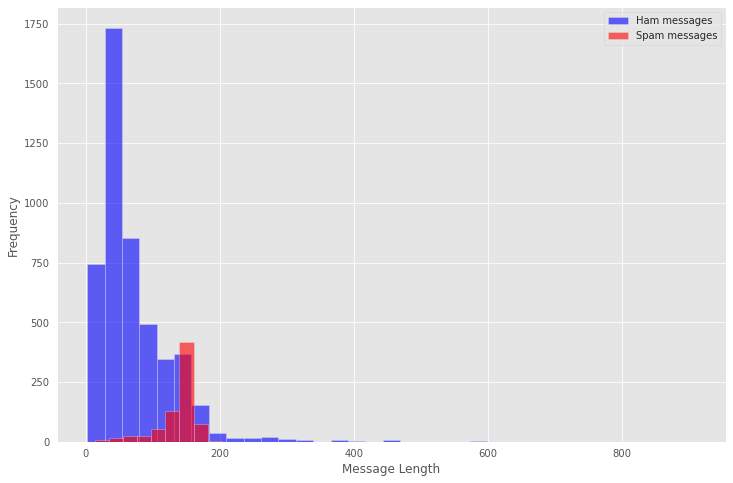

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use('ggplot')

plt.figure(figsize=(12,8))

data_rawSMS[data_rawSMS.label=='ham'].length.plot(
    bins=35, kind='hist', color='blue',
    label='Ham messages', alpha=0.6)
data_rawSMS[data_rawSMS.label=='spam'].length.plot(
    kind='hist', color='red',
    label='Spam messages', alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

In [9]:
#lab
data_rawSMS[data_rawSMS.label=='spam'].describe()

,length
count,747.000000
mean,138.866131
std,29.183082
min,13.000000
25%,132.500000
50%,149.000000
75%,157.000000
max,224.000000


In [10]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [12]:
def text_process(mess):
    CustomStopwords = ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    STOPWORDS = stopwords.words('english')+ CustomStopwords
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])

data_rawSMS['clean_msg'] = data_rawSMS.content.apply(text_process)
data_rawSMS.head()

,label,content,length,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though


In [13]:
#convert label to numerical variable
data_rawSMS['label_num'] = data_rawSMS.label.map({'ham':0, 'spam':1})
data_rawSMS.head()

,label,content,length,clean_msg,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts 21s...,1
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though,0


In [14]:
#Top 20 單字出現頻率(整體)
from collections import Counter

def get_words(content):
    words = []
    for row in content:
        for j in row.split():
            words.append(j.strip()) #strip->把前後空白刪掉
    return words

counter = Counter(get_words(data_rawSMS['clean_msg']))
most_common = dict(counter.most_common(20))
print(most_common)

{'call': 576, 'get': 386, 'go': 278, 'ok': 277, 'ltgt': 276, 'free': 275, 'know': 257, 'like': 242, 'got': 238, 'ill': 237, 'good': 234, 'come': 226, 'time': 208, 'day': 202, 'love': 195, 'want': 192, 'send': 190, 'text': 188, 'going': 171, 'one': 170}


<AxesSubplot:>

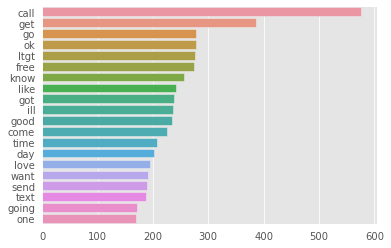

In [15]:
#對 Top 20 單字出現頻率畫圖(整體)
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))

In [16]:
#Top 50 單字出現頻率(spam)
from collections import Counter

words = data_rawSMS[data_rawSMS.label=='spam'].clean_msg.apply(lambda x: [word for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


In [17]:
X = data_rawSMS.clean_msg
y = data_rawSMS.label_num

#shape -> 檔案的大小
print('clean_msg 的總比數：{}'.format(X.shape))
print('label_num 的總比數：{}'.format(y.shape))

clean_msg 的總比數：(5572,)
label_num 的總比數：(5572,)


In [18]:
#拆分資料
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, train_size=0.8) # or test_size=0.2
#random_state -> 固定切割資料的結果
#train_size和test_size設定一邊即可，介於[0,1]之間

#看拆分後結果，EX: y_train
y_train

1114    0
3589    0
3095    0
1012    0
3320    0
       ..
4931    0
3264    1
1653    0
2607    0
2732    0
Name: label_num, Length: 4457, dtype: int64

In [19]:
#將文字轉換為數值向量形式(計算TF -> 單詞在「單一文件」的出現頻率)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
X_train_tf = vect.fit_transform(X_train)

In [20]:
pd.DataFrame(X_train_tf.toarray(), columns = vect.get_feature_names())
#大部分都是0的矩陣稱為「稀疏矩陣」，容易被計算

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02072069400,...,åòits,åôrents,ìll,ìï,ìïll,ûthanks,ûï,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#將文字轉換為數值向量形式(計算TF-IDF -> 單詞在「單一文件」和「所有文件」的出現頻率)
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_tf)
X_train_tfidf = tfidf_transformer.transform(X_train_tf)

In [22]:
pd.options.display.float_format = "{:,.4f}".format #小數點後四位

#看每個字的IDF值
pd.DataFrame([tfidf_transformer.idf_], columns=vect.get_feature_names())

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02072069400,...,åòits,åôrents,ìll,ìï,ìïll,ûthanks,ûï,ûïharry,ûò,ûówell
0,8.3038,8.7093,8.7093,8.7093,8.3038,8.7093,8.7093,7.7930,8.3038,8.7093,...,8.7093,8.7093,8.7093,5.7915,8.7093,8.7093,8.7093,8.7093,7.6107,8.7093


In [23]:
pd.options.display.float_format = "{:,.10f}".format

#看TF-IDF值
pd.DataFrame(X_train_tfidf.toarray(), columns = vect.get_feature_names())

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02072069400,...,åòits,åôrents,ìll,ìï,ìïll,ûthanks,ûï,ûïharry,ûò,ûówell
0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.3839798817,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4453,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4454,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.2362246265,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4455,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [24]:
from sklearn.ensemble import RandomForestClassifier

#n_estimators -> 總共建立n棵決策樹，此值越大效果越好，但要訓練很9
#oob_score -> 使用「袋外(Out of bag)樣本」測試，預設是False。設True只是要讓其他樹可以用那些沒被決策樹用到的value來繼續生成tree

rf = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=0)
%time clf = rf.fit(X_train_tfidf, y_train)

#有分(X_train、y_train 是訓練集，其中的X代表清洗後的message，y則是換成0(ham)或是1(spam)的數值)
#   (X_test、y_test 是測試集)

CPU times: user 252 ms, sys: 1.57 ms, total: 253 ms
Wall time: 256 ms


In [25]:
#使用驗證集測試模型的準確率accuracy
#Q: 訓練集內包含驗證集還有測試集
print("使用袋外數據(驗證集)測得的分數：", rf.oob_score_)

使用袋外數據(驗證集)測得的分數： 0.9685887368184878


In [26]:
#查看Top10重要的分類特徵
sorted(zip(rf.feature_importances_, vect.get_feature_names()), reverse=True)[0:10]

[(0.03208769475397031, 'call'),
 (0.03009187209886268, 'txt'),
 (0.026421942886505668, 'stop'),
 (0.022712736132855703, 'claim'),
 (0.021208908882061117, 'free'),
 (0.019173775412939704, 'mobile'),
 (0.0161211499795171, 'nokia'),
 (0.015262506258600202, 'reply'),
 (0.013336643881804073, '500'),
 (0.013154469561045028, 'text')]

In [27]:
#自行輸入訊息並加以預測
SMS = 'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.'
clean_text = text_process(SMS)

simple_test_tf = vect.transform([clean_text])

y_predSimpleTest_class = rf.predict(simple_test_tf.reshape(1,-1))

if int(y_predSimpleTest_class) == 1:
    print('spam: {}'.format(SMS))
else:
    print('ham: {}'.format(SMS))

ham: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.


In [28]:
from sklearn.metrics import confusion_matrix

y_predTest_class = rf.predict(vect.transform(X_test))
confusion_matrix(y_test, y_predTest_class)

array([[949,   0],
       [ 45, 121]])

In [29]:
### Type I error(嚴重) ###
# Predict: Ham=0 & Actual: Spam=1

print(len(X_test[(y_predTest_class==0) & (y_test==1)]))
print(X_test[(y_predTest_class==0) & (y_test==1)])

45
2078                         85233 freeringtonereply real
15      xxxmobilemovieclub use credit click wap link n...
348     fancy shag dointerested sextextukcom txt xxuk ...
1892    call 09090900040 listen extreme dirty live cha...
3753    bloomberg message center 447797706009 wait app...
304     sms ac blind date 4u rodds1 21m aberdeen unite...
4966    donate å£250 unicefs asian tsunami disaster su...
1457    claire havin borin time alone wanna cum 2nite ...
4963    dear voucher holder next meal us use following...
4067    tbspersolvo chasing us since sept forå£38 defi...
5566    reminder o2 get 250 pounds free call credit de...
5381                       1 new message call 02070836089
5492    marvel mobile play official ultimate spiderman...
3883    link picture sent also use httpalto18coukwavew...
1939    people dogging area call 09090204448 join like...
138     youll rcv msgs chat svc free hardcore services...
2294                1 new message please call 08718738034
2939       

In [30]:
#Accuracy準確率 (所有郵件(垃圾+有效)中，能夠正確預測多少比例的郵件)
from sklearn.metrics import accuracy_score

y_predTest_class = rf.predict(vect.transform(X_test))

print('Accuracy score: {}'.format(accuracy_score(y_test, y_predTest_class)))
#若資料正反例不平衡的狀況下，該指標不具參考價值

Accuracy score: 0.9596412556053812


In [31]:
#Recall召回率 (所有實際是垃圾郵件中，能夠預測(召回)出多少比例的垃圾郵件)
from sklearn.metrics import recall_score

y_predTest_class = rf.predict(vect.transform(X_test))

print('Recall score: {}'.format(recall_score(y_test, y_predTest_class)))

Recall score: 0.7289156626506024


In [32]:
#Precision精確率 (所有預測的垃圾郵件中，有多少比例(實際)為垃圾郵件)
from sklearn.metrics import precision_score

y_predTest_class = rf.predict(vect.transform(X_test))

print('Precision score: {}'.format(precision_score(y_test, y_predTest_class)))

Precision score: 1.0


In [33]:
#F1-score綜合評估標準，值越大越好 (通常precision和recall都會一個高一個低，所以會用F1-score來看這個模型預測的準不準)
from sklearn.metrics import f1_score

y_predTest_class = rf.predict(vect.transform(X_test))
print('F1 score: {}'.format(f1_score(y_test, y_predTest_class)))

#那如果要比較哪個模型比較準，就要去建新模型，再算出新的F1-score來比較！

F1 score: 0.8432055749128919


In [34]:
#評估模型 -> 這邊可以直接列出全部！
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_predTest_class))
print()
print(confusion_matrix(y_test, y_predTest_class))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       949
           1       1.00      0.73      0.84       166

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115


[[949   0]
 [ 45 121]]
